In [13]:
#Import packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import itertools

#Visuals
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
import plotly_express as px
import plotly.io as pio 
pio.renderers.default='notebook'

#Profile for features
import pandas_profiling

#Models
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import recall_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

In [14]:
# Import the Sloan Digital Sky Survery DR14 dataset
df = pd.read_csv('SDSS.csv')

In [15]:
# See what our dataset looks like
df.head()

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   
3  15.90438  752    301       4    269  3.722370e+18    STAR -0.000111   3306   
4  16.61326  752    301       4    269  3.722370e+18    STAR  0.000590   3306   

     mjd  fiberid  
0  54922      491  
1  51615      541  
2  52023      513  
3  54922      510  
4  54922      512

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [17]:
df.isna().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

- Run, rerun, and camcol deals with the CCD camera and how it takes the image of the spcified object
- Plate refers to the specific plate that was used to photograph the image, where holes are drilled into the plate
- where the objects being imaged will have there light be fed into that specific hole, where a fiber optic cable is then 
- placed in that hole, to then feed in that photometric spectrum of that object. 
- mjd is the dither number so all the pixels are replaced with good pixels 
- Specobjid just referes to the specific id of the object being imaged 
- Along with the objidjust refers to the objects id, which is unique to that stellar object

# EDA

In [18]:
df['label'] = pd.Categorical(df['class'], categories = ['STAR', 'GALAXY', 'QSO'])

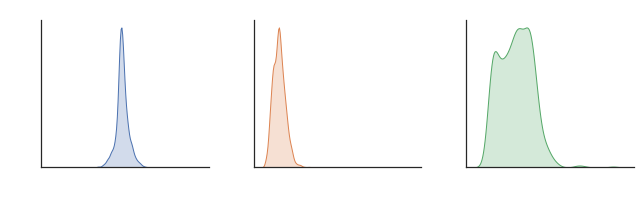

In [19]:
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
g = sns.FacetGrid(df, col='label', hue='label', margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'redshift', shade=True)
g.savefig("redshift.png")

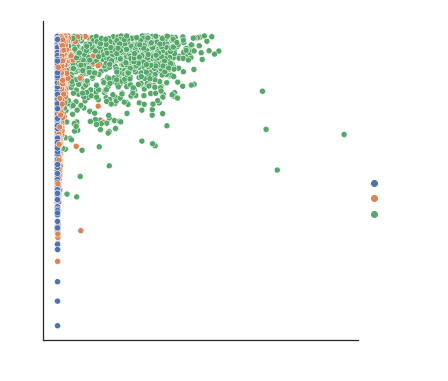

In [20]:
ax = sns.relplot(x = 'redshift', y = 'u', hue = 'class', data = df)
ax.fig.suptitle("Relationship between redshift & uv", x = 0.4, y= 1.01);

In [21]:
bands = df[['u', 'g', 'r', 'i', 'z']]
n_class = df['class']
box = pd.concat([n_class, bands], axis=1)
box = pd.melt(box, id_vars="class",
                    var_name="Photometric System",
                    value_name='value')

In [22]:
fig = px.box(box, x="Photometric System",y='value',color='class',title='Box plots - Photometric System (u, g, r, i, z) by class')
#              color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, marker_line_color="black")).update_layout( paper_bgcolor='rgb(243, 243, 243)',
#     plot_bgcolor='rgb(243, 243, 243)')
fig.show()

In [23]:
box = pd.concat([n_class,bands],axis=1)
box = pd.concat([n_class, bands],axis=1)
box = pd.melt(box,id_vars="class",
                    var_name="Photometric System",
                    value_name='value')
fig = px.box(box, x="Photometric System",y='value',title='Box plots - Photometric System (u, g, r, i, z)',
             color_discrete_sequence=px.colors.qualitative.Safe).update_traces(dict(marker_line_width=1, 
marker_line_color="black")).update_layout( paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)')
fig.show()